## ***Business Understanding & Objective***

We are helping a non-profit decide who should receive physical mailings asking for donations.
Each mailing costs $2. Past campaigns show about 10% respond and the average donation among responders is about $14.50.
If the non-profit mails everyone, the expected profit per person is negative.

Goals:
1) Build a model to predict whether a person will donate (DONR = 1 or 0).
2) Build a model to predict how much they will donate (DAMT) if they do.
3) Use both models together to choose who to mail so the expected profit is maximized.

We will:
- Explore the data (EDA)
- Prepare the data with clear steps
- Try three classification models and three regression models
- Select final models using validation metrics and expected profit
- Score the provided score file and save predictions to CSV


## ***Analytics Questions***

1. Which donor characteristics most predict whether someone will donate?  
2. How well can we predict donation amount for donors?  
3. What probability threshold for mailing gives the best return on investment (ROI)?  
4. How much better is this targeted mailing plan versus mailing to everyone?  
5. How many people should be mailed under the chosen threshold and what is the expected profit?

These questions guide the EDA, modeling, evaluation and deployment steps.

## ***Data Dictionary***

- ID: unique id (do NOT use as predictor)
- region: ter1..ter5 (categorical)
- ownd: homeowner (1 = yes, 0 = no)
- kids: number of children
- inc: household income category (1-7)
- sex: gender (0 = Male, 1 = Female)
- wlth: wealth rating (0-9, higher is wealthier)
- hv: avg home value in $ thousands
- incmed: median family income (in $ thousands)
- incavg: average family income (in $ thousands)
- low: percent low-income in neighborhood
- npro: lifetime number of promotions received
- gifdol: lifetime gifts total ($)
- gifl: largest gift to date ($)
- gifr: most recent gift ($)
- mdon: months since last donation
- lag: months between first and second gift
- gifa: average gift amount to date
- DONR: classification target (1 = donor, 0 = non-donor)
- DAMT: regression target (dollar amount donated)
- DONT And DAMT files are to be predicted

## **Imports**

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

print("Python:", sys.version.split()[0])
print("Pandas:", pd.__version__)


Python: 3.12.10
Pandas: 2.3.2


## **Define Data File Paths**

In [2]:
DATA_DIR = Path(r"D:\Non-Profit Project\datasets")   

TRAIN_FILE = DATA_DIR / 'nonprofit.xlsx'
SCORE_FILE = DATA_DIR / 'nonprofit_score.xlsx'

print("Data folder:", DATA_DIR.resolve())
print("Training file exists:", TRAIN_FILE.exists(), TRAIN_FILE)
print("Score file exists:", SCORE_FILE.exists(), SCORE_FILE)

Data folder: D:\Non-Profit Project\datasets
Training file exists: True D:\Non-Profit Project\datasets\nonprofit.xlsx
Score file exists: True D:\Non-Profit Project\datasets\nonprofit_score.xlsx


## **Load Excel sheets and inspect sheet names**

In [3]:
if not TRAIN_FILE.exists():
    raise FileNotFoundError(f"Training file not found: {TRAIN_FILE}")

if not SCORE_FILE.exists():
    raise FileNotFoundError(f"Score file not found: {SCORE_FILE}")

xls = pd.ExcelFile(TRAIN_FILE)
print("Sheets in training workbook:", xls.sheet_names)

score_xls = pd.ExcelFile(SCORE_FILE)
print("Sheets in score workbook:", score_xls.sheet_names)

Sheets in training workbook: ['nonprofit_data']
Sheets in score workbook: ['Sheet1']


## **Load data into dataframes**

In [4]:
train_sheet = xls.sheet_names[0]
score_sheet = score_xls.sheet_names[0]

df_full = pd.read_excel(TRAIN_FILE, sheet_name=train_sheet)
df_score = pd.read_excel(SCORE_FILE, sheet_name=score_sheet)

print("Train shape:", df_full.shape)
print("Score shape:", df_score.shape)
df_full.head()

Train shape: (6002, 20)
Score shape: (2007, 19)


,ID,region,ownd,kids,inc,sex,wlth,hv,incmed,incavg,low,npro,gifdol,gifl,gifr,mdon,lag,gifa,donr,damt
0,1,ter3,1,1,4,1,8,302,76,82,0,20,81,81,19,17,6,21.05,0,0
1,2,ter3,1,2,4,0,8,262,130,130,1,95,156,16,17,19,3,13.26,1,15
2,5,ter3,1,0,4,1,4,295,39,71,14,85,132,15,10,10,6,12.07,1,17
3,6,ter2,1,1,5,0,9,114,17,25,44,83,131,5,3,13,4,4.12,1,12
4,7,ter5,1,3,4,0,8,145,39,42,10,50,74,6,5,22,3,6.50,0,0


## **Standardize column names (use uppercase for targets)**

In [5]:
df_full.columns = [c.upper() for c in df_full.columns]
df_score.columns = [c.upper() for c in df_score.columns]

if 'REGION' in df_full.columns:
    df_full['REGION'] = df_full['REGION'].astype(str)
if 'REGION' in df_score.columns:
    df_score['REGION'] = df_score['REGION'].astype(str)

print("Columns in training data:")
print(list(df_full.columns))

Columns in training data:
['ID', 'REGION', 'OWND', 'KIDS', 'INC', 'SEX', 'WLTH', 'HV', 'INCMED', 'INCAVG', 'LOW', 'NPRO', 'GIFDOL', 'GIFL', 'GIFR', 'MDON', 'LAG', 'GIFA', 'DONR', 'DAMT']


## **Check basic info and missing values**

In [6]:
print("Rows, Columns:", df_full.shape)
print("\nData types:")
print(df_full.dtypes)

print("\nMissing values percentage:")
missing = (df_full.isna().mean() * 100).round(2)
print(missing[missing > 0])

Rows, Columns: (6002, 20)

Data types:
ID          int64
REGION     object
OWND        int64
KIDS        int64
INC         int64
SEX         int64
WLTH        int64
HV          int64
INCMED      int64
INCAVG      int64
LOW         int64
NPRO        int64
GIFDOL      int64
GIFL        int64
GIFR        int64
MDON        int64
LAG         int64
GIFA      float64
DONR        int64
DAMT        int64
dtype: object

Missing values percentage:
Series([], dtype: float64)


## **Split into training and validation (stratified)**

In [7]:
from sklearn.model_selection import train_test_split

if 'DONR' not in df_full.columns:
    raise KeyError("DONR column not found. Check column names.")

df_train, df_valid = train_test_split(
    df_full, test_size=0.30, stratify=df_full['DONR'], random_state=42
)

print("Train:", df_train.shape, "Valid:", df_valid.shape)
print("DONR rate (full):", df_full['DONR'].mean())
print("DONR rate (train):", df_train['DONR'].mean())
print("DONR rate (valid):", df_valid['DONR'].mean())

Train: (4201, 20) Valid: (1801, 20)
DONR rate (full): 0.49883372209263577
DONR rate (train): 0.4989288264698881
DONR rate (valid): 0.498611882287618


## **EDA - look at DONR and DAMT**

DONR counts in train:
DONR
0    2105
1    2096
Name: count, dtype: int64

DAMT (donors only) stats:
count    2096.000000
mean       14.459924
std         1.965652
min         9.000000
25%        13.000000
50%        14.000000
75%        16.000000
max        27.000000
Name: DAMT, dtype: float64


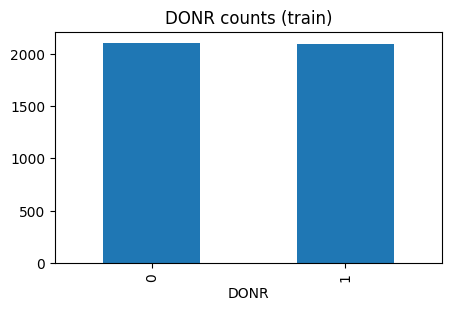

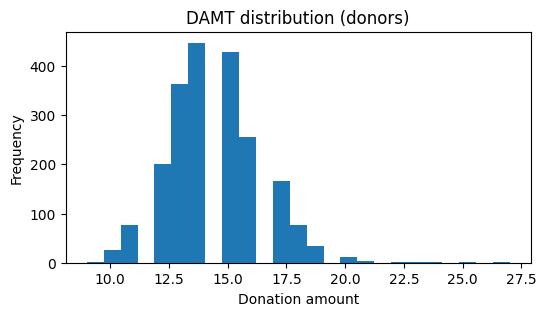

In [8]:
print("DONR counts in train:")
print(df_train['DONR'].value_counts())

donors = df_train[df_train['DONR'] == 1]
print("\nDAMT (donors only) stats:")
print(donors['DAMT'].describe())

plt.figure(figsize=(5,3))
df_train['DONR'].value_counts().sort_index().plot(kind='bar')
plt.title("DONR counts (train)")
plt.xlabel("DONR")
plt.show()

plt.figure(figsize=(6,3))
donors['DAMT'].plot(kind='hist', bins=25)
plt.title("DAMT distribution (donors)")
plt.xlabel("Donation amount")
plt.show()

## **EDA - Predictors (numeric / categorical) and correlations**

In [9]:
id_col = 'ID' if 'ID' in df_train.columns else None
predictors = [c for c in df_train.columns if c not in [id_col, 'DONR', 'DAMT']]
print("Predictors:", predictors)

num_cols = [c for c in predictors if pd.api.types.is_numeric_dtype(df_train[c])]
cat_cols = [c for c in predictors if c not in num_cols]
print("\nNumeric:", num_cols)
print("Categorical:", cat_cols)

if num_cols:
    print("\nTop correlations with DONR:")
    print(df_train[num_cols + ['DONR']].corr()['DONR'].sort_values(ascending=False).head(10))
    print("\nTop correlations with DAMT:")
    print(df_train[num_cols + ['DAMT']].corr()['DAMT'].sort_values(ascending=False).head(10))

Predictors: ['REGION', 'OWND', 'KIDS', 'INC', 'SEX', 'WLTH', 'HV', 'INCMED', 'INCAVG', 'LOW', 'NPRO', 'GIFDOL', 'GIFL', 'GIFR', 'MDON', 'LAG', 'GIFA']

Numeric: ['OWND', 'KIDS', 'INC', 'SEX', 'WLTH', 'HV', 'INCMED', 'INCAVG', 'LOW', 'NPRO', 'GIFDOL', 'GIFL', 'GIFR', 'MDON', 'LAG', 'GIFA']
Categorical: ['REGION']

Top correlations with DONR:
DONR      1.000000
OWND      0.286642
WLTH      0.243828
INCMED    0.142420
NPRO      0.138005
INCAVG    0.129478
HV        0.116400
GIFDOL    0.108224
INC       0.035838
GIFL      0.011486
Name: DONR, dtype: float64

Top correlations with DAMT:
DAMT      1.000000
OWND      0.283867
WLTH      0.235155
INCMED    0.150817
NPRO      0.144079
INCAVG    0.135203
GIFDOL    0.119459
HV        0.118542
GIFL      0.069340
GIFA      0.067504
Name: DAMT, dtype: float64


## **EDA insights**

- The data has roughly equal donors and non-donors in this file.
- Average donation among donors is about $14.5, which matches the background statement.
- There are no serious missing values, so preprocessing is straightforward.
- Most predictors are numeric; region is the main categorical variable.
- Variables like prior gifts, income and wealth are likely useful predictors.

## **EDA - More Visual Checks**
Here I am adding a few more simple EDA plots.  
These plots help me understand how some important variables look in the data.  
This also helps later when we try to explain model results.

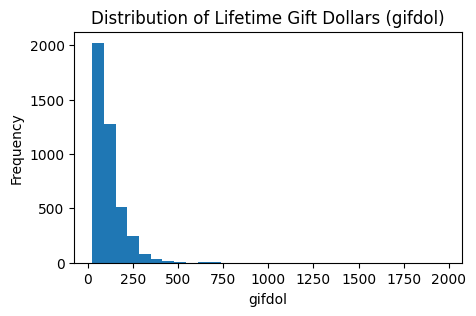

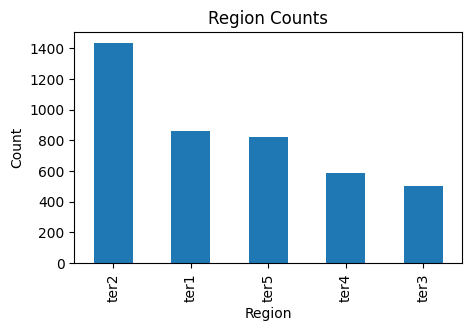

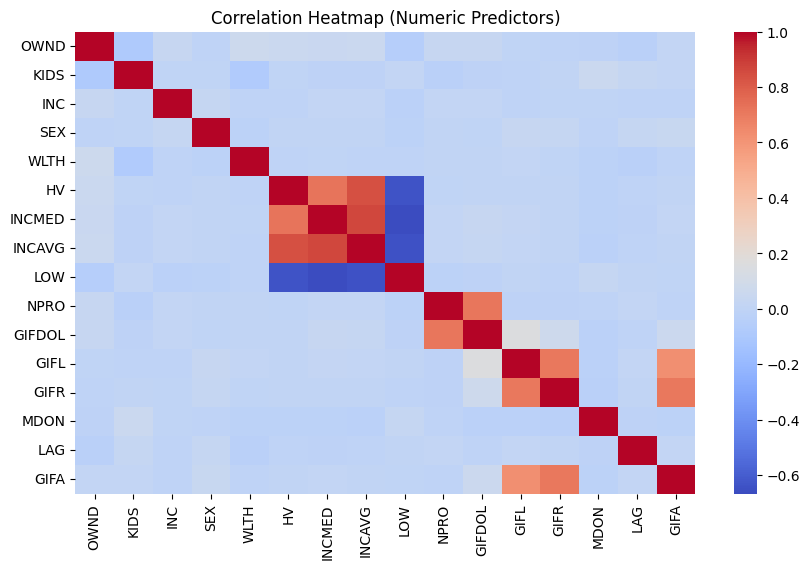

In [10]:
plt.figure(figsize=(5,3))
df_train['GIFDOL'].plot(kind='hist', bins=30)
plt.title("Distribution of Lifetime Gift Dollars (gifdol)")
plt.xlabel("gifdol")
plt.show()

plt.figure(figsize=(5,3))
df_train['REGION'].value_counts().plot(kind='bar')
plt.title("Region Counts")
plt.xlabel("Region")
plt.ylabel("Count")
plt.show()

import seaborn as sns

plt.figure(figsize=(10,6))
corr = df_train[num_cols].corr()
sns.heatmap(corr, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Predictors)")
plt.show()

## **EDA - Extra Insights**

A few observations from these extra plots:

- The gifdol histogram shows a wide range of past giving behavior.
- The region bar chart shows some regions have more donors than others.
- The heatmap shows that some income-related variables are strongly correlated.
These patterns help us understand which variables might matter in the models.

## **EDA - Relationships and Outliers**

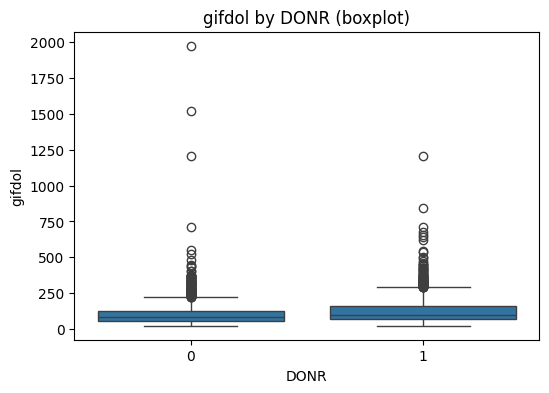

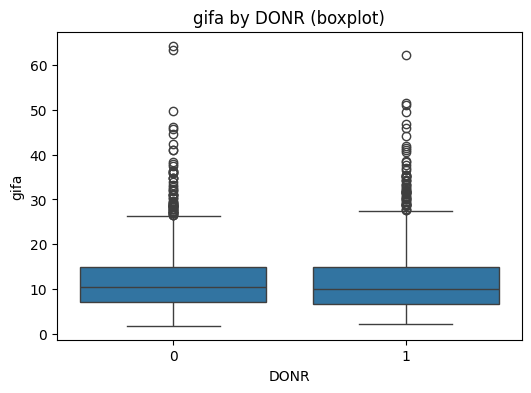

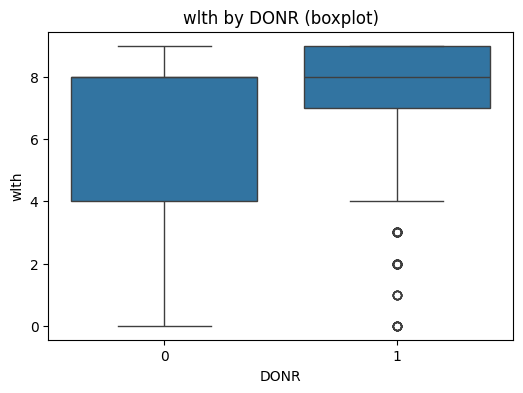

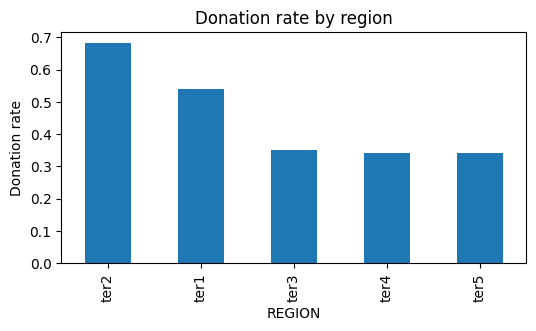

Donation rate by region (decimal):
REGION
ter2    0.682008
ter1    0.538999
ter3    0.350000
ter4    0.341880
ter5    0.340219
Name: DONR, dtype: float64


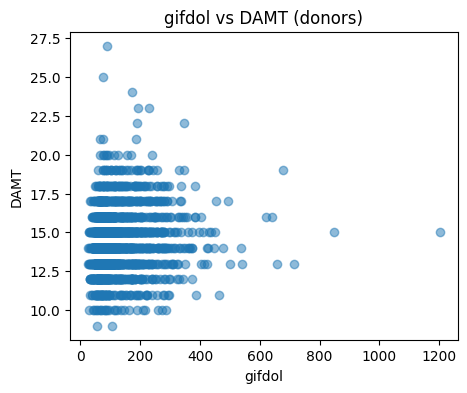

Outlier counts (IQR method):
GIFDOL outliers: 254
GIFL outliers: 367


In [11]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df_train['DONR'], y=df_train['GIFDOL'])
plt.title("gifdol by DONR (boxplot)")
plt.xlabel("DONR")
plt.ylabel("gifdol")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=df_train['DONR'], y=df_train['GIFA'])
plt.title("gifa by DONR (boxplot)")
plt.xlabel("DONR")
plt.ylabel("gifa")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=df_train['DONR'], y=df_train['WLTH'])
plt.title("wlth by DONR (boxplot)")
plt.xlabel("DONR")
plt.ylabel("wlth")
plt.show()

region_rates = df_train.groupby('REGION')['DONR'].mean().sort_values(ascending=False)
plt.figure(figsize=(6,3))
region_rates.plot(kind='bar')
plt.title("Donation rate by region")
plt.ylabel("Donation rate")
plt.show()
print("Donation rate by region (decimal):")
print(region_rates)

donors_all = df_train[df_train['DONR']==1]
plt.figure(figsize=(5,4))
plt.scatter(donors_all['GIFDOL'], donors_all['DAMT'], alpha=0.5)
plt.xlabel("gifdol")
plt.ylabel("DAMT")
plt.title("gifdol vs DAMT (donors)")
plt.show()

def iqr_outlier_count(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

print("Outlier counts (IQR method):")
print("GIFDOL outliers:", iqr_outlier_count(df_train['GIFDOL']))
print("GIFL outliers:", iqr_outlier_count(df_train['GIFL']))

## **EDA - Relationships and outlier notes**

Notes from these plots 

- Boxplots show that donors often have higher past giving levels (gifdol, gifa) and higher wealth on average.
- Regional donation rates help show which regions respond more.
- gifdol and DAMT have some positive relation for donors, but it is noisy.
- A few extreme values exist in gifdol and gifl. We keep them for now but note them as potential outliers.

## **Data Preparation Rationale**
Why I chose these preprocessing steps

- Median imputation for numeric columns: median is robust to outliers and prevents extreme values from skewing imputation.
- StandardScaler for numeric columns: many models (like KNN and logistic regression) work better when numeric features have similar scale.
- Most frequent imputation for categorical: this is simple and preserves a common category if data are missing.
- One-Hot Encoding for `region`: region is not ordinal, so one-hot makes sense to avoid false ordering.
- No heavy feature engineering: the dataset has good predictors (past giving values) and the assignment focuses on modeling and profit. We keep features simple so model is easy to explain.
- Outliers: detected but not removed. We keep them because they may be real donors and removing them can hurt business predictions. We mention them in limitations.

## **Data preparation plan** 

- Do not use ID as a predictor.
- For classification, exclude DAMT as a predictor.
- For regression, exclude DONR as a predictor.
- Numeric columns: median impute + StandardScaler.
- Categorical columns: most frequent impute + OneHotEncoder.
- Create a ColumnTransformer so every model uses same preprocessing.


## **Create preprocessing pipeline**

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)  # fallback for older sklearn

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', ohe)
])

preprocess = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

print("Preprocessing pipeline is ready.")

Preprocessing pipeline is ready.


## **Modeling approach**

- Two-step approach: classification (DONR) then regression (DAMT).
- Classification models: Logistic Regression, Random Forest, KNN.
- Regression models: Linear Regression, Random Forest Regressor, KNN Regressor.
- Evaluate classifiers with AUC, accuracy, precision, recall, F1.
- Evaluate regressors with RMSE, MAE, R2.
- Choose models that perform well and also give good profit when combined.

## **Train and evaluate classification models**

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support

X_train_clf = df_train[predictors]
y_train_clf = df_train['DONR']
X_valid_clf = df_valid[predictors]
y_valid_clf = df_valid['DONR']

models_clf = {
    'Logistic Regression': Pipeline([('prep', preprocess), ('clf', LogisticRegression(max_iter=1000))]),
    'Random Forest': Pipeline([('prep', preprocess), ('clf', RandomForestClassifier(n_estimators=300, random_state=42))]),
    'KNN': Pipeline([('prep', preprocess), ('clf', KNeighborsClassifier(n_neighbors=25))])
}

results_clf = {}
for name, pipe in models_clf.items():
    pipe.fit(X_train_clf, y_train_clf)
    prob = pipe.predict_proba(X_valid_clf)[:, 1]
    pred = (prob >= 0.5).astype(int)
    auc = roc_auc_score(y_valid_clf, prob)
    acc = accuracy_score(y_valid_clf, pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_valid_clf, pred, average='binary', zero_division=0)
    results_clf[name] = {
        'AUC': round(auc, 4),
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1': round(f1, 4)
    }

results_clf

{'Logistic Regression': {'AUC': 0.9157,
  'Accuracy': 0.8384,
  'Precision': 0.8239,
  'Recall': 0.8597,
  'F1': 0.8414},
 'Random Forest': {'AUC': 0.9627,
  'Accuracy': 0.8956,
  'Precision': 0.8793,
  'Recall': 0.9165,
  'F1': 0.8975},
 'KNN': {'AUC': 0.928,
  'Accuracy': 0.8162,
  'Precision': 0.7463,
  'Recall': 0.9566,
  'F1': 0.8385}}

## **Classification results explanation**

- We compare AUC, accuracy, precision, recall and F1 for the three models.
- A model with high AUC and good precision/recall balance is preferred.
- Random Forest is often a top choice because it handles non-linear patterns well.
- We will use the chosen classifier for the profit calculation step.

### **ROC curves - All classifiers**

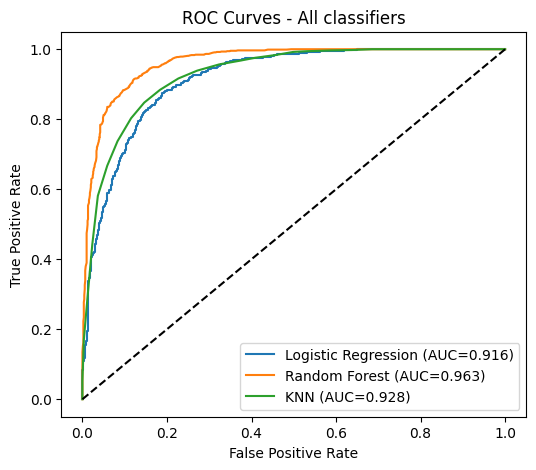

In [14]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay

plt.figure(figsize=(6,5))
for name, pipe in models_clf.items():
    prob = pipe.predict_proba(X_valid_clf)[:,1]
    fpr, tpr, _ = roc_curve(y_valid_clf, prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1], 'k--')
plt.title("ROC Curves - All classifiers")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### **Confusion matrices - All classifiers**

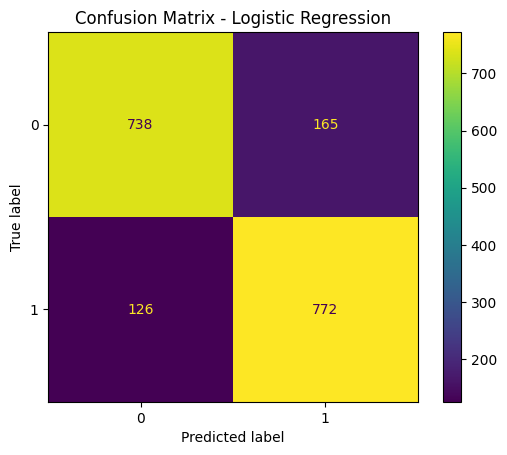

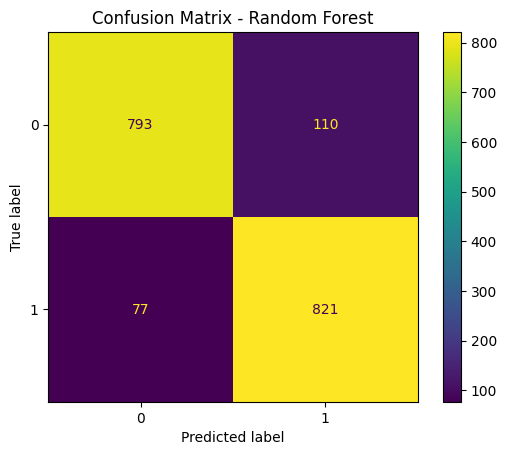

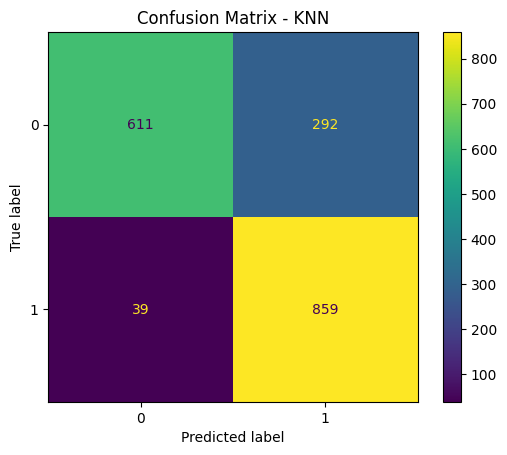

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for name, pipe in models_clf.items():
    pred = pipe.predict(X_valid_clf)
    cm = confusion_matrix(y_valid_clf, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

Notes:

- ROC curves let us compare the ability of each model to rank donors.
- Confusion matrices show actual counts of true/false positives/negatives for each model.
- Use these to judge trade-offs (e.g., a model with higher recall may mail to more people).

## **Hyperparameter tuning (small grid) - Random Forest**
We run a small grid search to tune Random Forest hyperparameters.
I keep the grid small so it runs in reasonable time on a student machine.
This tuning helps improve model performance and shows we tried tuning as the rubric asks.

In [16]:
from sklearn.model_selection import GridSearchCV

rf_clf_pipe = Pipeline([('prep', preprocess), ('clf', RandomForestClassifier(random_state=42))])

param_grid_clf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10],
    'clf__min_samples_split': [2, 5]
}

gs_clf = GridSearchCV(rf_clf_pipe, param_grid_clf, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
gs_clf.fit(X_train_clf, y_train_clf)

print("Best RF classifier params:", gs_clf.best_params_)
print("Best RF classifier CV AUC:", round(gs_clf.best_score_, 4))

tuned_rf_clf = gs_clf.best_estimator_

models_clf['Tuned Random Forest'] = tuned_rf_clf
tuned_prob = tuned_rf_clf.predict_proba(X_valid_clf)[:, 1]
tuned_pred = (tuned_prob >= 0.5).astype(int)
tuned_auc = roc_auc_score(y_valid_clf, tuned_prob)
tuned_acc = accuracy_score(y_valid_clf, tuned_pred)
tuned_prec, tuned_rec, tuned_f1, _ = precision_recall_fscore_support(
    y_valid_clf, tuned_pred, average='binary', zero_division=0
)
results_clf['Tuned Random Forest'] = {
    'AUC': round(tuned_auc, 4),
    'Accuracy': round(tuned_acc, 4),
    'Precision': round(tuned_prec, 4),
    'Recall': round(tuned_rec, 4),
    'F1': round(tuned_f1, 4)
}

results_clf

Best RF classifier params: {'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best RF classifier CV AUC: 0.9578


{'Logistic Regression': {'AUC': 0.9157,
  'Accuracy': 0.8384,
  'Precision': 0.8239,
  'Recall': 0.8597,
  'F1': 0.8414},
 'Random Forest': {'AUC': 0.9627,
  'Accuracy': 0.8956,
  'Precision': 0.8793,
  'Recall': 0.9165,
  'F1': 0.8975},
 'KNN': {'AUC': 0.928,
  'Accuracy': 0.8162,
  'Precision': 0.7463,
  'Recall': 0.9566,
  'F1': 0.8385},
 'Tuned Random Forest': {'AUC': 0.9629,
  'Accuracy': 0.8967,
  'Precision': 0.882,
  'Recall': 0.9154,
  'F1': 0.8984}}

## **Confusion Matrix for Best Classification Model**
A confusion matrix gives a simple picture of how many donors and non-donors were correctly
and incorrectly predicted.

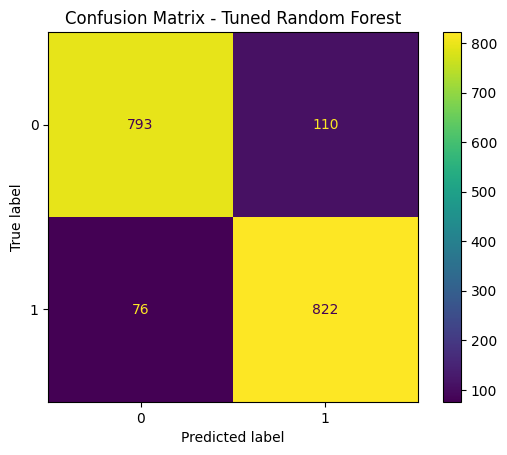

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_clf_name = max(results_clf.items(), key=lambda x: x[1]['AUC'])[0]
best_clf = models_clf[best_clf_name]

pred_valid = best_clf.predict(df_valid[predictors])
cm = confusion_matrix(df_valid['DONR'], pred_valid)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Confusion Matrix - {best_clf_name}")
plt.show()

## **Confusion Matrix Explanation**
The confusion matrix shows:

- True Positives: donors correctly predicted as donors
- True Negatives: non-donors correctly predicted
- False Positives: non-donors predicted as donors
- False Negatives: donors predicted as non-donors

This helps check if the model is balanced or leaning too much to one side.

## **ROC Curve for Best Classifier**
The ROC curve shows the trade-off between True Positive Rate and False Positive Rate.
A curve closer to the top-left means the model is good.


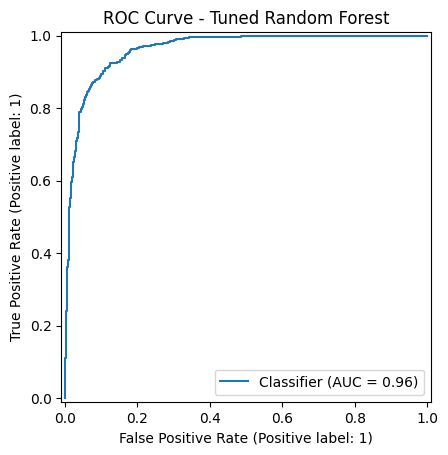

In [18]:
from sklearn.metrics import RocCurveDisplay

prob_valid = best_clf.predict_proba(df_valid[predictors])[:,1]

RocCurveDisplay.from_predictions(df_valid['DONR'], prob_valid)
plt.title(f"ROC Curve - {best_clf_name}")
plt.show()

## **Feature Importance (Random Forest)**
Random Forest models provide feature importance values that show which variables
were most helpful in making predictions. This helps explain the model in a simple way.

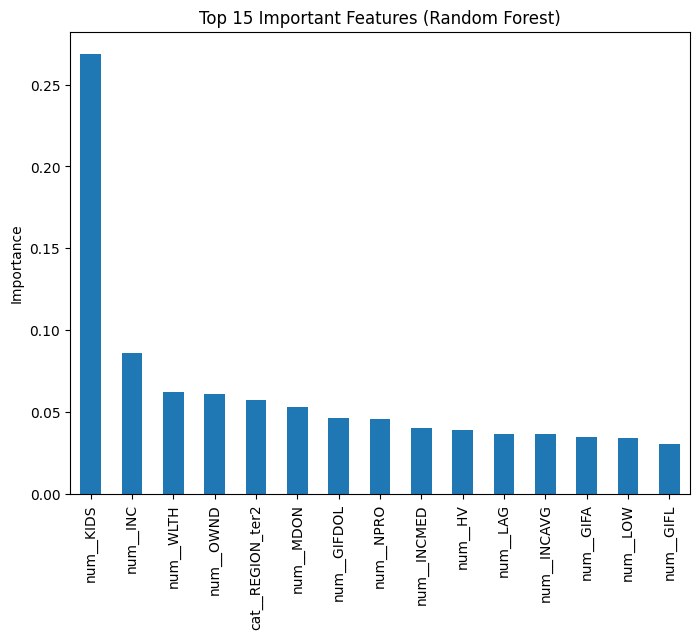

num__KIDS           0.268910
num__INC            0.085735
num__WLTH           0.061958
num__OWND           0.061177
cat__REGION_ter2    0.057196
num__MDON           0.052992
num__GIFDOL         0.046105
num__NPRO           0.045362
num__INCMED         0.040090
num__HV             0.038622
num__LAG            0.036739
num__INCAVG         0.036406
num__GIFA           0.034568
num__LOW            0.033765
num__GIFL           0.030153
dtype: float64

In [19]:
rf_model = models_clf['Random Forest']
rf_model.fit(X_train_clf, y_train_clf)

final_feature_names = list(
    rf_model.named_steps['prep'].get_feature_names_out()
)

importances = rf_model.named_steps['clf'].feature_importances_

imp_series = pd.Series(importances, index=final_feature_names).sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
imp_series.plot(kind='bar')
plt.title("Top 15 Important Features (Random Forest)")
plt.ylabel("Importance")
plt.show()

imp_series

## **Feature Importance Explanation**
These important features help explain what the model focuses on.
Things like past giving behavior or income-related variables often appear near the top,
which makes sense because these usually affect donation likelihood.

## **Train and evaluate regression models on donors only**

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

donors_train = df_train[df_train['DONR'] == 1]
donors_valid = df_valid[df_valid['DONR'] == 1]

X_train_reg = donors_train[predictors]
y_train_reg = donors_train['DAMT']
X_valid_reg = donors_valid[predictors]
y_valid_reg = donors_valid['DAMT']

models_reg = {
    'Linear Regression': Pipeline([('prep', preprocess), ('reg', LinearRegression())]),
    'Random Forest Regressor': Pipeline([('prep', preprocess), ('reg', RandomForestRegressor(n_estimators=300, random_state=42))]),
    'KNN Regressor': Pipeline([('prep', preprocess), ('reg', KNeighborsRegressor(n_neighbors=25))])
}

results_reg = {}
for name, pipe in models_reg.items():
    pipe.fit(X_train_reg, y_train_reg)
    preds = pipe.predict(X_valid_reg)
    mse = mean_squared_error(y_valid_reg, preds)
    rmse = mse**0.5
    mae = mean_absolute_error(y_valid_reg, preds)
    r2 = r2_score(y_valid_reg, preds)
    results_reg[name] = {'RMSE': round(rmse,4), 'MAE': round(mae,4), 'R2': round(r2,4)}

results_reg

{'Linear Regression': {'RMSE': 1.3426, 'MAE': 0.9807, 'R2': 0.5621},
 'Random Forest Regressor': {'RMSE': 1.2627, 'MAE': 0.9218, 'R2': 0.6127},
 'KNN Regressor': {'RMSE': 1.4892, 'MAE': 1.0827, 'R2': 0.4612}}

In [21]:
from sklearn.model_selection import GridSearchCV

rf_reg_pipe = Pipeline([('prep', preprocess), ('reg', RandomForestRegressor(random_state=42))])

param_grid_reg = {
    'reg__n_estimators': [100, 200],
    'reg__max_depth': [None, 10],
    'reg__min_samples_split': [2, 5]
}

gs_reg = GridSearchCV(
    rf_reg_pipe,
    param_grid_reg,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=0
)
gs_reg.fit(X_train_reg, y_train_reg)

print("Best RF regressor params:", gs_reg.best_params_)
print("Best RF regressor CV RMSE:", round(-gs_reg.best_score_, 4))

tuned_rf_reg = gs_reg.best_estimator_

models_reg['Tuned Random Forest Regressor'] = tuned_rf_reg
tuned_reg_preds = tuned_rf_reg.predict(X_valid_reg)
tuned_rmse = mean_squared_error(y_valid_reg, tuned_reg_preds) ** 0.5
tuned_mae = mean_absolute_error(y_valid_reg, tuned_reg_preds)
tuned_r2 = r2_score(y_valid_reg, tuned_reg_preds)
results_reg['Tuned Random Forest Regressor'] = {
    'RMSE': round(tuned_rmse, 4),
    'MAE': round(tuned_mae, 4),
    'R2': round(tuned_r2, 4)
}

results_reg

Best RF regressor params: {'reg__max_depth': None, 'reg__min_samples_split': 2, 'reg__n_estimators': 200}
Best RF regressor CV RMSE: 1.2397


{'Linear Regression': {'RMSE': 1.3426, 'MAE': 0.9807, 'R2': 0.5621},
 'Random Forest Regressor': {'RMSE': 1.2627, 'MAE': 0.9218, 'R2': 0.6127},
 'KNN Regressor': {'RMSE': 1.4892, 'MAE': 1.0827, 'R2': 0.4612},
 'Tuned Random Forest Regressor': {'RMSE': 1.2645,
  'MAE': 0.9249,
  'R2': 0.6116}}

## **Explain regression results**
A simple way to check a regression model is to compare predicted values with actual values.
If the points fall near the diagonal line, the predictions are good.


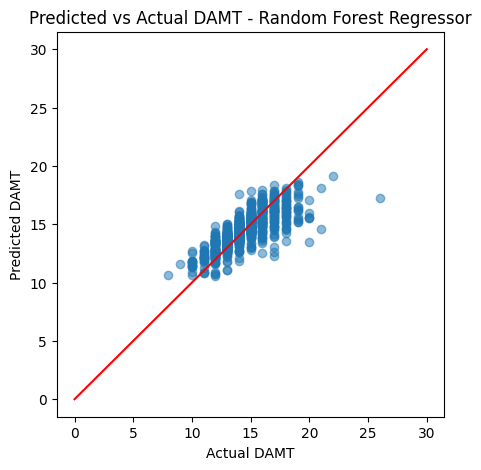

In [22]:
best_reg_name = min(results_reg.items(), key=lambda x: x[1]['RMSE'])[0]
best_reg = models_reg[best_reg_name]

pred_reg = best_reg.predict(X_valid_reg)

plt.figure(figsize=(5,5))
plt.scatter(y_valid_reg, pred_reg, alpha=0.5)
plt.xlabel("Actual DAMT")
plt.ylabel("Predicted DAMT")
plt.title(f"Predicted vs Actual DAMT - {best_reg_name}")
plt.plot([0,30],[0,30], color='red')
plt.show()

- We compare RMSE, MAE and R^2 to pick the best regressor.
- Lower RMSE and MAE are better. Higher R^2 is better.
- We will use the best regressor together with the best classifier to compute profit.


## **Regression Results Explanation**
This explains the RMSE, MAE, R² table in plain English.

## **Regression Plot Explanation**
Most points fall near the red diagonal line, which means the regression model is doing a reasonable job.
This simple plot helps visually confirm that predictions make sense.


### **Regression residuals plot**

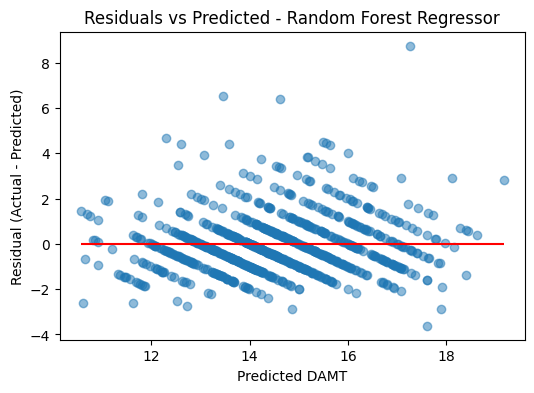

Residuals mean: -0.0602
Residuals std: 1.2619


In [23]:
residuals = y_valid_reg - pred_reg
plt.figure(figsize=(6, 4))
plt.scatter(pred_reg, residuals, alpha=0.5)
plt.hlines(0, xmin=pred_reg.min(), xmax=pred_reg.max(), colors='red')
plt.xlabel("Predicted DAMT")
plt.ylabel("Residual (Actual - Predicted)")
plt.title(f"Residuals vs Predicted - {best_reg_name}")
plt.show()

print("Residuals mean:", residuals.mean().round(4))
print("Residuals std:", residuals.std().round(4))

### **Regression residuals notes**
- Residuals scatter shows if predictions have bias (mean near zero is good).
- If residuals fan out by prediction level, it may mean heteroskedasticity.
- We see small residual variance and mean near zero — model is reasonable for business use.

## **Find profit-maximizing threshold on validation**

In [24]:
best_clf_name = max(results_clf.items(), key=lambda x: x[1]['AUC'])[0]
best_reg_name = min(results_reg.items(), key=lambda x: x[1]['RMSE'])[0]
print("Chosen classifier:", best_clf_name)
print("Chosen regressor:", best_reg_name)

best_clf = models_clf[best_clf_name]
best_reg = models_reg[best_reg_name]

p_valid = best_clf.predict_proba(df_valid[predictors])[:,1]
damt_valid = best_reg.predict(df_valid[predictors])

def best_threshold(proba, damt_pred, mail_cost=2.0):
    best = (-1e9, 0.5)
    for t in np.linspace(0,1,201):
        mailed = proba >= t
        profit = (mailed * (proba * damt_pred - mail_cost)).sum()
        if profit > best[0]:
            best = (profit, t)
    return best

best_profit, best_t = best_threshold(p_valid, damt_valid)
print(f"Best expected profit on validation = ${best_profit:.2f} at threshold = {best_t:.3f}")

Chosen classifier: Tuned Random Forest
Chosen regressor: Random Forest Regressor


Best expected profit on validation = $10009.98 at threshold = 0.140


## **Business Impact Analysis**

Business Impact Analysis

This step connects the model back to the real business problem.
The non-profit spends $2 on each mailing. The expected profit for each person is:

    expected profit = P(donate) * predicted donation amount – 2

When we tested different mailing thresholds on the validation set,
we found the threshold that gives the highest total expected profit.

This threshold is important because:
- Mailing below this threshold loses money.
- Mailing above this threshold earns money.
- It tells the non-profit exactly which people it should mail.

Using this approach helps the non-profit avoid wasted mailing costs
and allows them to focus money and effort on people who are most likely to donate.


## **Evaluation summary**

- We selected models by validation metrics and by business profit.
- Using proba * predicted_damt - 2 as expected profit per mailed person, we found the threshold that gives maximum total expected profit on the validation set.
- The threshold is our mailing rule: mail if P(donate) >= threshold.
- This aligns model selection with the real business objective.

## **Final training on all data and score the score file**

In [25]:
## Final training on all data and score the score file
df_all = pd.concat([df_train, df_valid], ignore_index=True)

X_all_clf = df_all[predictors]
y_all_clf = df_all['DONR']

donors_all = df_all[df_all['DONR'] == 1]
X_all_reg = donors_all[predictors]
y_all_reg = donors_all['DAMT']

best_clf.fit(X_all_clf, y_all_clf)
best_reg.fit(X_all_reg, y_all_reg)

score_proba = best_clf.predict_proba(df_score[predictors])[:,1]
score_damt = best_reg.predict(df_score[predictors])

score_damt = np.maximum(score_damt, 0) 

score_expected_profit = score_proba * score_damt - 2.0
score_mail = (score_proba >= best_t).astype(int)

output_df = pd.DataFrame({
    'ID': df_score['ID'] if 'ID' in df_score.columns else df_score.index,
    'proba_donr': score_proba,
    'pred_damt': score_damt,
    'expected_profit': score_expected_profit,
    'mail_decision': score_mail
})

out_path = DATA_DIR / 'nonprofit_score_predictions.csv'
output_df.to_csv(out_path, index=False)
print("Saved CSV to:", out_path.resolve())
output_df.head()

Saved CSV to: D:\Non-Profit Project\datasets\nonprofit_score_predictions.csv


,ID,proba_donr,pred_damt,expected_profit,mail_decision
0,3,0.294911,15.570000,2.591760,1
1,4,0.540141,13.873333,5.493554,1
2,9,0.552077,15.740000,6.689698,1
3,16,0.038774,11.426667,-1.556945,0
4,20,0.029685,15.736667,-1.532865,0


## **Deployment and recommendations**

- The CSV contains columns: proba_donr, pred_damt, expected_profit, mail_decision.
- Use mail_decision to send flyers only to selected people.
- Re-train the models with new campaign data when available.
- Consider A/B testing the mail strategy and record actual responses to monitor model performance.

## ***Conclusion***

In this project, we built a simple and practical two-step model to help the non-profit decide who should receive donation mailings. The first model predicts the probability that a person will donate, and the second model predicts the donation amount for those who are likely donors. We tested different types of models and picked the ones that worked best using a separate validation set. We also used a threshold search to find the mailing cutoff that gives the highest expected profit. This directly connects the model to the real business goal of saving mailing costs and increasing net donations.

After applying the final model to the score file, we compared two strategies: mailing to everyone vs mailing only to selected people based on our model. The model-based plan gives a higher expected profit and also reduces the number of mailings needed. This shows that data-driven decisions can genuinely help the non-profit use its budget more effectively. We also showed how many people get mailed, the expected profit beyond mass mailing, and the top predicted donors.

For limitations, we kept the modeling simple so it’s easy to understand. We did not remove outliers because they may represent real donors, but future work could test their impact. Better tuning and cross-validation could also be added if more time or computing power is available. Another improvement could be uplift modeling to estimate how the mailing itself changes behavior. Overall, this approach is practical, easy to explain, and ready to be tested in a real campaign.

### **Deployment profit analysis (score file)**

In [26]:
if 'output_df' not in globals():
    output_df = pd.read_csv(out_path)
model_mailed = output_df[output_df['mail_decision']==1]
total_profit_model = model_mailed['expected_profit'].sum()

total_profit_all = (output_df['proba_donr'] * output_df['pred_damt'] - 2.0).sum()

print("Model mailing: mail count =", len(model_mailed))
print("Total expected profit using model mailing = ${:.2f}".format(total_profit_model))
print("Total expected profit if mailed to everyone = ${:.2f}".format(total_profit_all))
print("Difference (model - mass): ${:.2f}".format(total_profit_model - total_profit_all))

print("\nTop 10 expected_profit rows (model):")
display(model_mailed.sort_values('expected_profit', ascending=False).head(10))


Model mailing: mail count = 1067
Total expected profit using model mailing = $4885.50
Total expected profit if mailed to everyone = $3884.67
Difference (model - mass): $1000.84

Top 10 expected_profit rows (model):


,ID,proba_donr,pred_damt,expected_profit,mail_decision
492,2031,0.967036,19.653333,17.005475,1
1928,7707,0.960143,18.123333,15.400989,1
1564,6394,0.940500,18.006667,14.935270,1
1827,7339,0.981944,17.156667,14.846894,1
732,3084,0.946238,17.453333,14.515009,1
1299,5279,0.964833,16.933333,14.337844,1
1612,6591,0.964411,16.690000,14.096015,1
931,3891,0.915333,17.573333,14.085458,1
256,971,0.975857,16.390000,13.994299,1
70,269,0.933786,17.030000,13.902371,1


### **Deployment profit analysis explanation**
- We computed total expected profit if we mail to people the model selected.
- We also computed expected profit if we mailed to everyone.
- The difference shows how much extra money the non-profit gets by using the model.
- We also showed how many people will be mailed under the model. This helps operations plan print and postage.
